# **6. PyTorch Transfer Learning**

## What is transfer learning?
## Transfer Learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = Foundation models

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 1.13+

2.3.0+cu121
0.18.0+cu121


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [111]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [112]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **1. Get Data**

## We need our pizza, steak, sushi data to build a transfer learning model on.

In [113]:
# !wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

In [163]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a SUBSET of CLASSES from the Food101 DATASET

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download PIZZA, STEAK SUSHI DATA
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data ...")
    f.write(request.content)

  # Unzip PIZZA, STEAK, SUSHI DATA
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists, skipping re-download.


In [142]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('/content/data/pizza_steak_sushi/train'),
 PosixPath('/content/data/pizza_steak_sushi/test'))

## **2. Create  Datasets and DataLoaders**

Now we've got some data. Need to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There is one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's 2 ways to do this:

1. Manually created transforms - you define what transform you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

IMPORTANT POINT: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

In [143]:
from going_modular.going_modular import data_setup

### **2.1 Creating a transform for `torchvision.models` (manual creation)**
`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

All pretrained models expect input images normalized in the same way, i.e mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.255]. You can use the following transform to normalize.

In [144]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [145]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [146]:
from going_modular.going_modular import data_setup

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x790ad6413a60>,
 ['pizza', 'steak', 'sushi'])

### **2.2 Creating a transform for `torchvision.models` (auto creation)**

As of `torchvision` v0.13+ there's now support for automatic data transform creation based on the pretrained model weights you're using.

In [147]:
# Get a set of pretrained models weights.
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights. This is gonna be PATTERNS that the model has learned on IMAGENET.

In [148]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [149]:
# Create DataLoaders using automatic TRANSFORMS
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x790abc37d900>,
 ['pizza', 'steak', 'sushi'])

## **3. Getting a pretrained model**

There are various places to get a pretrained model. Such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### **3.1 Which pretrained model should I use?**

**Experiment! Experiment! Experiment!**

The whole idea of TRANSFER LEARNING: take an already well-performing model from a problem space similiar to your own and then CUSTOMIZE to your own problem.

## **Three things to consider:**
## 1. SPEED - How fast does it run? (If parameters are small, it works fast)
## 2. SIZE - How big is the model? (Parameters are small. It is VERY GOOD)
## 3. PERFORMANCE - How well does it go on your chosen problem (e.g: how well does it CLASSIFY food images?) For FoodVision Mini in our case.

## **Where does the MODEL LIVE?**

## Is it on DEVICE?

## Does it LIVE on a SERVER?

## Which MODEL should we CHOOSE?

## For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of the best options in terms of PERFORMANCE vs SIZE.

## However, in light of Bitter Lesson, if we had infinite compute, we'd  likely choose the biggest model + most parameters + most general we could.

### **3.2 Setting up a pretrained model**

Want to create an instance of a pretrained EffNetB0

https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html

# **model.features = Feature layers use patterns learned on the ImageNet**
# **model.avgpool = Average pool is going to collect all the features and collect them. And Average pool is going to compress all the features into a single vector.**
# **model.classifier = This is what we're gonna alter features and classifier head when we wanna customize this model to our own problem.**

In [150]:
# OLD METHOD of creating a pretrained model (prior to torchvision v0.13)
# MODEL - trochvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model(torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = BEST AVAILABLE WEIGHTS
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

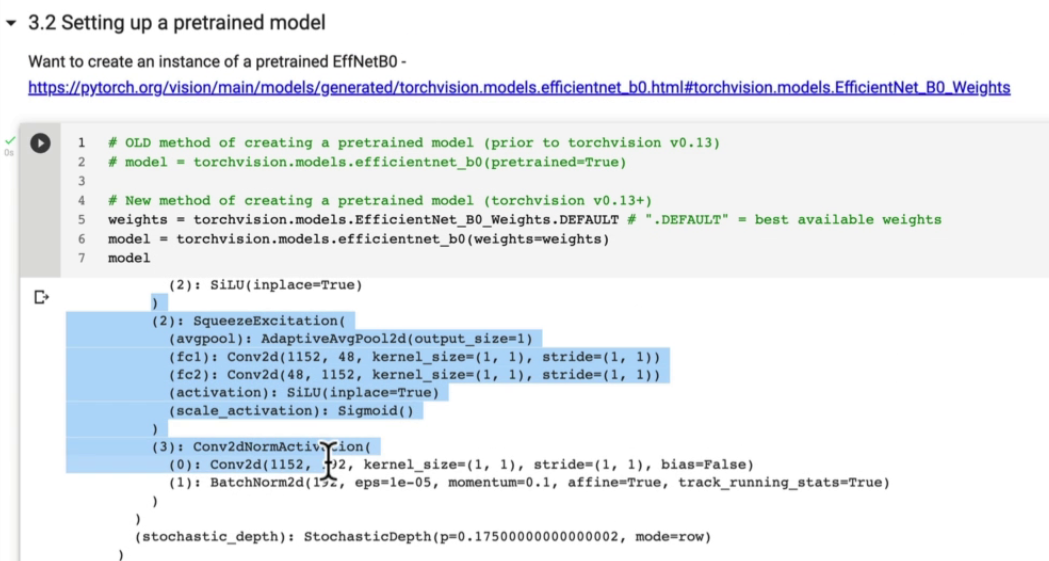

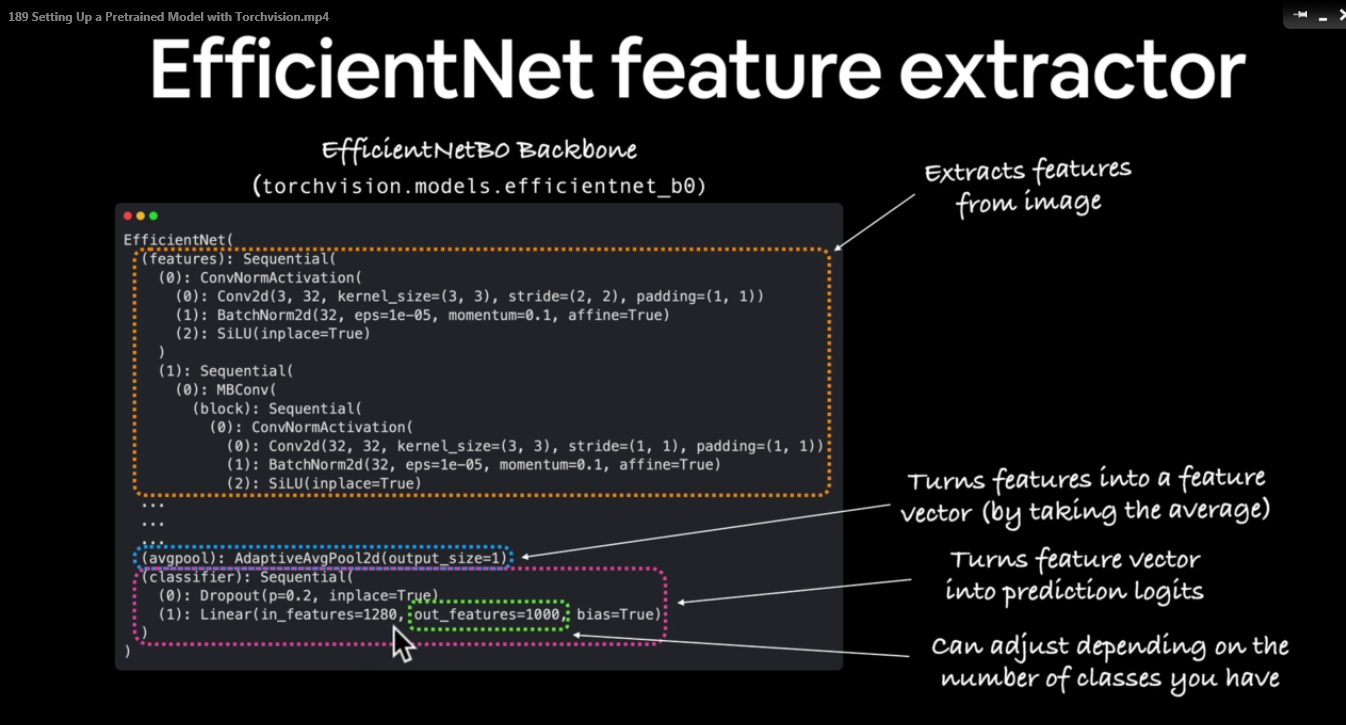

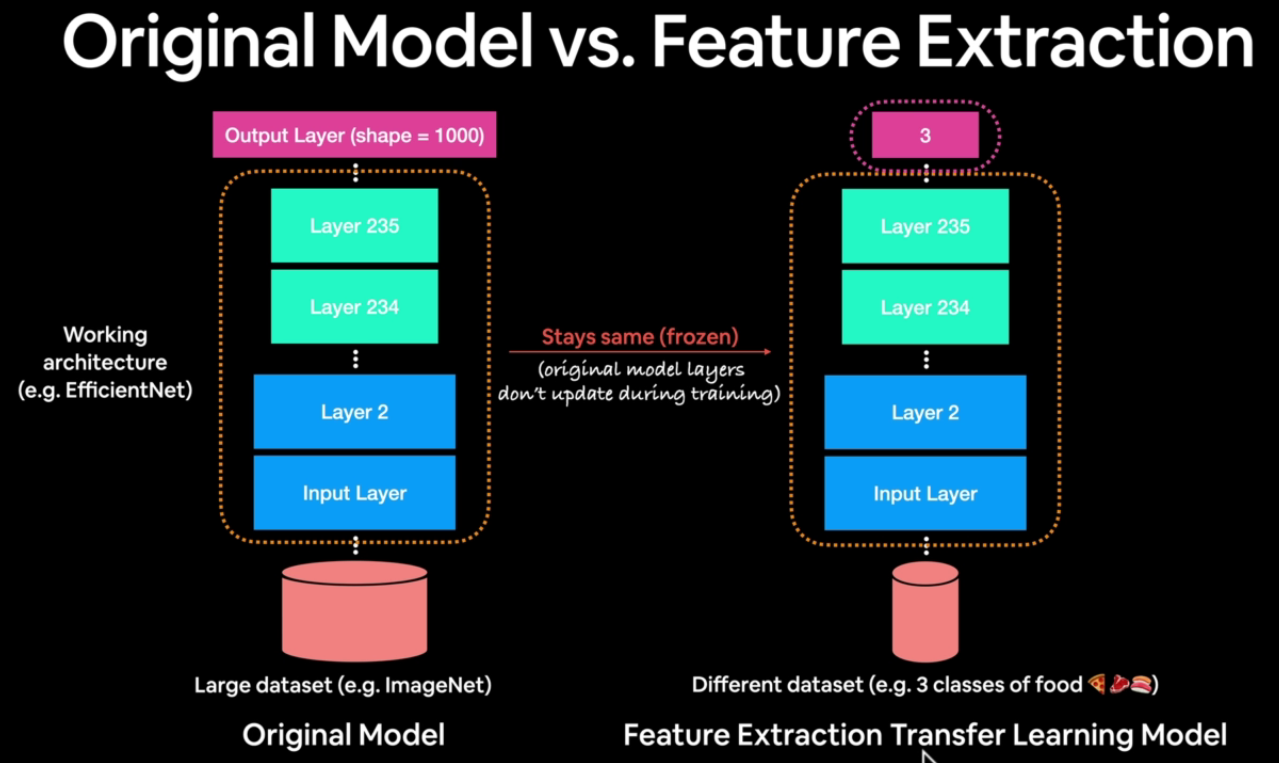

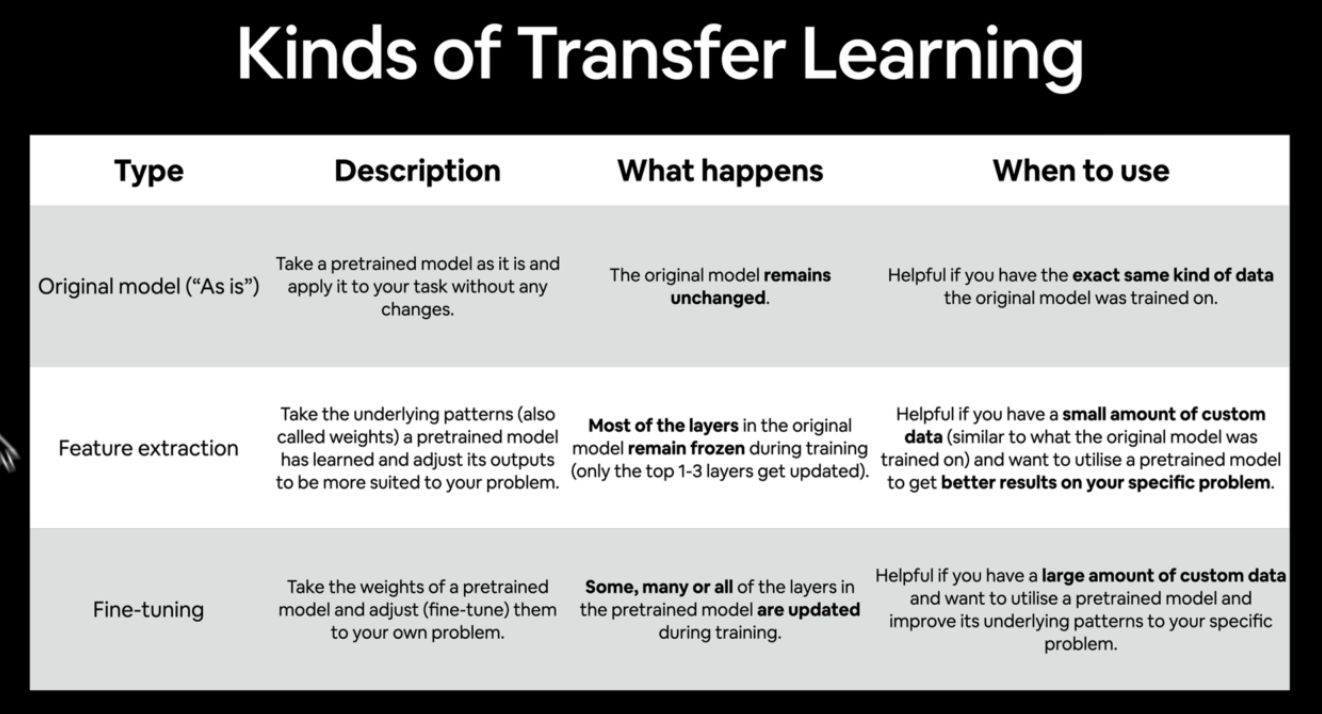

### **3.3 Getting a summary of our model with torchinfo.summary()**

In [151]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, heights width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential: 1-1                                       [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]    [1, 16, 112, 112]    --                   True
│    

### **3.4 Freezing the base model and changing the output layer to suit our needs**

## With a FEATURE EXTRACTOR MODEL, typically you'll "FREEZE" the base layers of a PRETRAINED/FOUNDATION MODEL and UPDATE the OUTPUT layers to suit your own problem.

In [152]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [153]:
len(class_names)

3

In [154]:
# Update the CLASSIFIER HEAD of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # Some of the neurons will be deactivated so that it can balance overfitting. 0.2 = 20%
  nn.Linear(in_features=1280, # Feature vector coming in)
            out_features=len(class_names))).to(device) # We have 3 classes. We use len() function to turn the class_names into an integer which is 3.

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [155]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, heights width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]    [1, 16, 112, 112]    --                   Fal

## **4. Train Model**

In [156]:
# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [157]:
# Import Train Function
from going_modular.going_modular import engine

# Set the manual seeds whenever you train or evaluate your model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# Enf the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 12.526 seconds


## **5. EVALUATE model by plotting LOSS CURVES**

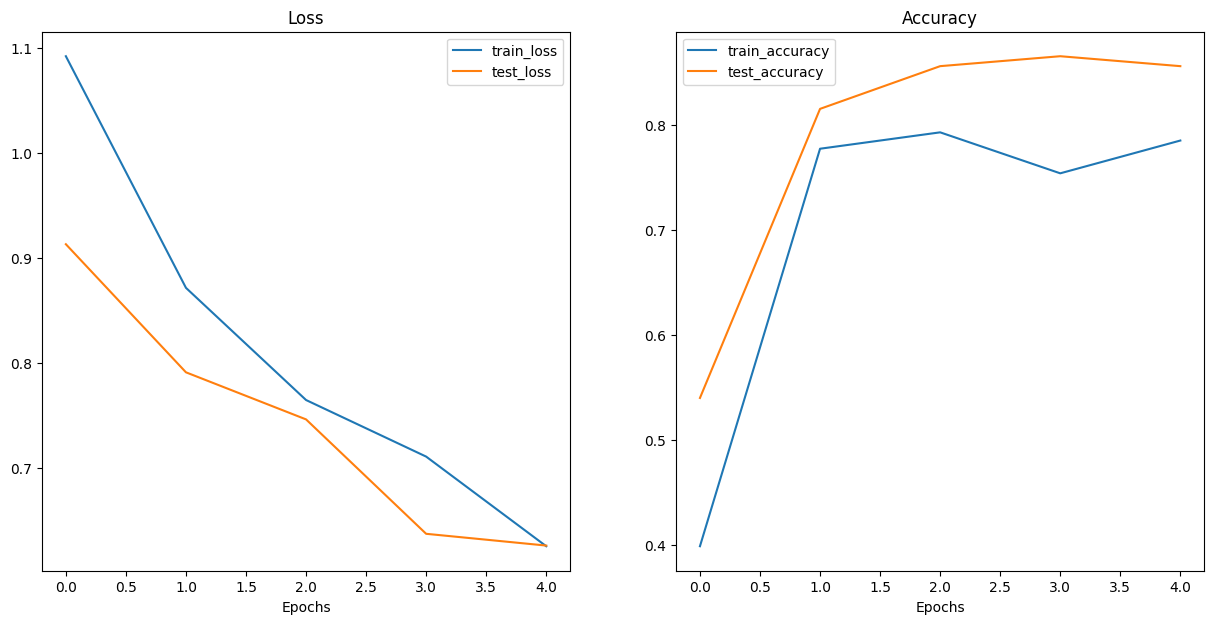

In [158]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open ("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the Loss Curves of our Model
plot_loss_curves(results)

# What should an ideal loss curves look like?

# See here - https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## **6. Make predictions on images from the test set**

Let's adhere to the data explorer's motto "Vizualize! Vizualize! Vizualize!"

Make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same **shape** - images need to be same shape as model was trained on
* Same **datatype** - custom data should be in the same datatype
* Same **device** - custom data/test data should be on the same device as the model
* Same **transform** - if you've transformed your custom data, ideally you'll transform the test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image()`:

See here - https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image,
an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will trun off things like `nn.Dropout()`) It's simply a REGULARIZATION layer to prevent OVERFITTING
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [159]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the Image with PIL
  img = Image.open(image_path)

  # 3. Create a TRANSFORM if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(), # Turn all of the values between 0 and 1
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
  ### PREDICT ON IMAGE ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also )
    target_image_pred = model(transformed_image.to(device)) # This is gonna be OUTPUT LOGITS

  # 8. Convert the model's output LOGITS to PREDICTION PROBABILITIES
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert the model's PREDICTION PROBABILITIES to PREDICTION LABELS
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot the image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

# **We need to take the MAXIMUM VALUE** of target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

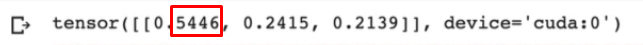

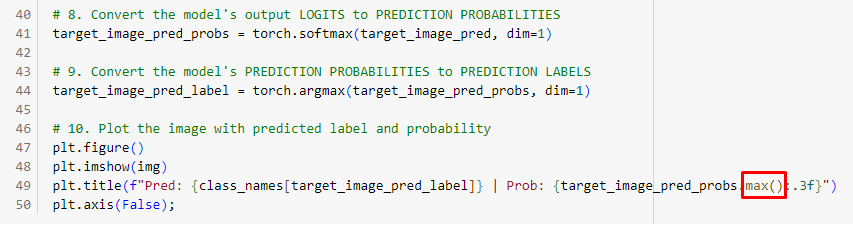

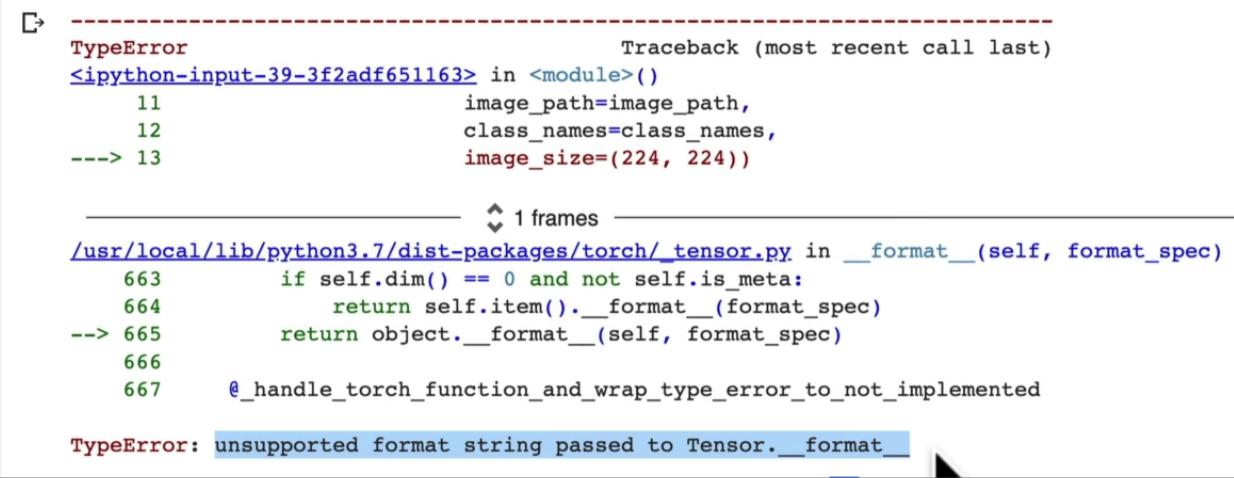

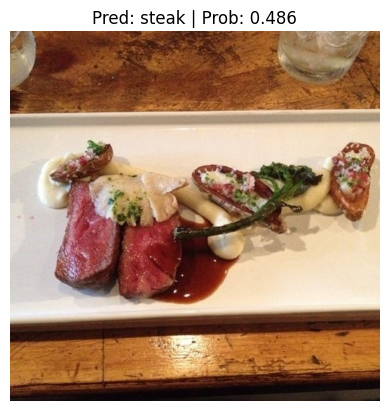

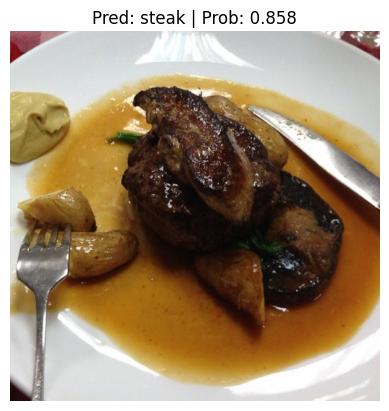

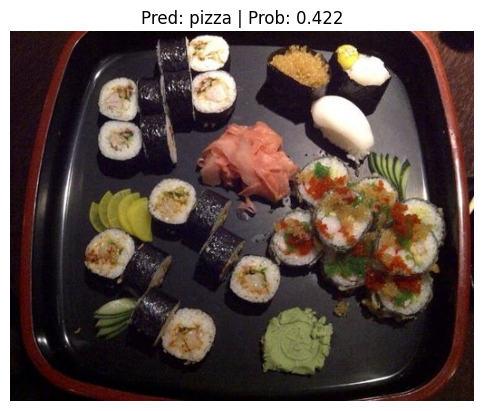

In [160]:
# Get a random list of image paths from the test set
import random
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_image_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### **6.1 Making predictions on a custom image**

Let's make a prediction on the pizza dad image - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images04-pizza-dad.jpeg

In [184]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "sushi.jpg"

# Download the image if image doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download the image from GitHub with "raw" link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/sushi.jpg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

data/sushi.jpg already exists, skipping download...


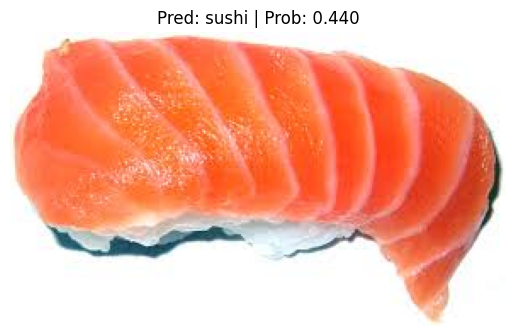

In [185]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)